<a href="https://colab.research.google.com/github/poojitharajapuram/HW6_ML/blob/main/HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
url = 'https://raw.githubusercontent.com/poojitharajapuram/HW6_ML/main/Housing.csv'
data_frame = pd.read_csv(url)
data_frame.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [4]:
data_frame['furnishingstatus'].value_counts().unique
data_frame.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [5]:
data_frame = pd.get_dummies(data_frame, columns=['furnishingstatus'], drop_first=False)
data_frame = data_frame.drop('furnishingstatus_semi-furnished', axis=1)
data_frame.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,1,0
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,1,0
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,0,0
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,1,0
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,1,0


In [6]:
binary_columns = data_frame.select_dtypes(include=['object']).columns
binary_columns

Index(['mainroad', 'guestroom', 'basement', 'hotwaterheating',
       'airconditioning', 'prefarea'],
      dtype='object')

In [7]:
data_frame[binary_columns] = data_frame[binary_columns].apply(lambda x: x.map({'yes': 1, 'no': 0}))
data_frame.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,0,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1,0


In [8]:
data_frame.shape

(545, 14)

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
X_scaler = MinMaxScaler()
Y_scaler= MinMaxScaler()

In [15]:
X = data_frame.drop('price', axis = 1)
y = data_frame[['price']]

In [16]:
X = pd.DataFrame(X_scaler.fit_transform(X), columns=X.columns, index=X.index).values
y = pd.DataFrame(Y_scaler.fit_transform(y), columns=y.columns, index=y.index).values

In [17]:
trainset_X, validation_X, trainset_Y, validation_Y = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.tensor(trainset_X)
y_train =  torch.tensor(trainset_Y)
X_validation =  torch.tensor(validation_X)
y_validation =  torch.tensor(validation_Y)

In [18]:
training_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)

In [19]:
val_data = TensorDataset(X_validation, y_validation)
val_loader = DataLoader(val_data, batch_size=32)

In [20]:
def model_train(model, criterion, optimizer, epochs, train_loader, X_validation, y_validation):
    loss_train = []
    loss_val = []
    for epoch in range(epochs + 1):
        # Training
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        # Validation
        model.eval()
        with torch.no_grad():
            validation_outputs = model(X_validation)
            validation_loss = criterion(validation_outputs, y_validation)
            if epoch % 500 == 0:
              print(f'Epoch {epoch}/{epochs}, Training Loss: {loss.item()}, Validation Loss: {validation_loss.item()}')
              loss_val.append(validation_loss)
              loss_train.append(loss)
    return loss_train, loss_val

1a


In [21]:

model1 = nn.Sequential(
    nn.Linear(X_train.shape[1], 32),
    nn.Tanh(),
    nn.Linear(32, 1)
).to(torch.float64)
optimizer1 = optim.SGD(model1.parameters(), lr=0.01)
train_loss, val_loss = model_train(model1, nn.MSELoss(), optimizer1, 5000, train_loader, X_validation, y_validation)


Epoch 0/5000, Training Loss: 0.04114479457254651, Validation Loss: 0.050694387061206776
Epoch 500/5000, Training Loss: 0.00735170196319051, Validation Loss: 0.013416667891719903
Epoch 1000/5000, Training Loss: 0.0065185053564309845, Validation Loss: 0.01332145424567893
Epoch 1500/5000, Training Loss: 0.004382039981478207, Validation Loss: 0.013451813658999971
Epoch 2000/5000, Training Loss: 0.004975508548316521, Validation Loss: 0.013420633050411853
Epoch 2500/5000, Training Loss: 0.0075092173175934085, Validation Loss: 0.01330583159191033
Epoch 3000/5000, Training Loss: 0.0066563674439807635, Validation Loss: 0.01333972149653111
Epoch 3500/5000, Training Loss: 0.0067093459886037165, Validation Loss: 0.013383273516000844
Epoch 4000/5000, Training Loss: 0.002352285332800749, Validation Loss: 0.013260289917980155
Epoch 4500/5000, Training Loss: 0.0031729429069430313, Validation Loss: 0.01338022477530028
Epoch 5000/5000, Training Loss: 0.0032720290472958956, Validation Loss: 0.01325220268

In [24]:
for name, parameter in model1.named_parameters():
    print(f"Parameter name: {name}, Shape: {parameter.shape}")


Parameter name: 0.weight, Shape: torch.Size([32, 13])
Parameter name: 0.bias, Shape: torch.Size([32])
Parameter name: 2.weight, Shape: torch.Size([1, 32])
Parameter name: 2.bias, Shape: torch.Size([1])


In [25]:
total_parameters = sum(p.numel() for p in model1.parameters() if p.requires_grad)
print("Total number of trainable parameters ", total_parameters,  '\n')

Total number of trainable parameters  481 



In [26]:
epochs = range(0, 5001, 500)
epochs


range(0, 5001, 500)

<ipython-input-27-0bc7f5a83e0e>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)


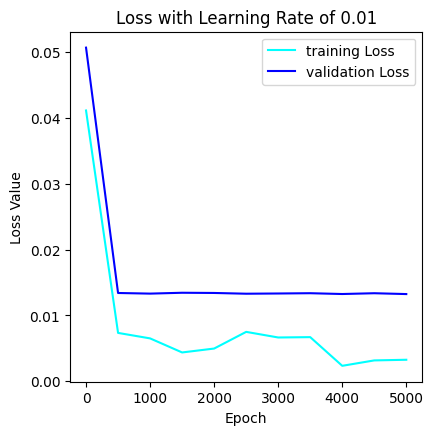

In [27]:
plt.figure(figsize=(10, 10))
plt.title('SGD optimizer loss comparison')

plt.subplot(2,2,1)
plt.plot(epochs, np.array([item.detach().item() for item in train_loss]), color='cyan', label = 'training Loss')
plt.plot(epochs, np.array([item.detach().item() for item in val_loss]), color='blue', label = 'validation Loss')
plt.title('Loss with Learning Rate of 0.01')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

plt.show()
plt.show()

1b


In [28]:
model2 = nn.Sequential(
    nn.Linear(X_train.shape[1], 32),
    nn.Tanh(),
    nn.Linear(32, 64),
    nn.Tanh(),
    nn.Linear(64, 16),
    nn.Tanh(),
    nn.Linear(16, 1)
).to(torch.float64)
criterion = nn.MSELoss()
optimizer2 = optim.SGD(model2.parameters(), lr=0.01)
train_loss_2, val_loss_2 = model_train(model2, nn.MSELoss(), optimizer2, 5000, train_loader, X_validation, y_validation)

Epoch 0/5000, Training Loss: 0.03932383375360735, Validation Loss: 0.0903667810004865
Epoch 500/5000, Training Loss: 0.007898084648021253, Validation Loss: 0.013286864020610512
Epoch 1000/5000, Training Loss: 0.009152645734655686, Validation Loss: 0.013305436799278739
Epoch 1500/5000, Training Loss: 0.012994743129207079, Validation Loss: 0.013373749747977502
Epoch 2000/5000, Training Loss: 0.013895068404455502, Validation Loss: 0.013332137954333828
Epoch 2500/5000, Training Loss: 0.006801079001227917, Validation Loss: 0.0133650657655069
Epoch 3000/5000, Training Loss: 0.005398007584161352, Validation Loss: 0.013429588208071788
Epoch 3500/5000, Training Loss: 0.004941653237210382, Validation Loss: 0.013421690582198982
Epoch 4000/5000, Training Loss: 0.015198657113251208, Validation Loss: 0.013331278377565576
Epoch 4500/5000, Training Loss: 0.006185107842112247, Validation Loss: 0.01336943426978659
Epoch 5000/5000, Training Loss: 0.00411584749359135, Validation Loss: 0.0134209326835739


In [29]:
for name, parameter in model2.named_parameters():
    print(f"Parameter name: {name}, Shape: {parameter.shape}")

Parameter name: 0.weight, Shape: torch.Size([32, 13])
Parameter name: 0.bias, Shape: torch.Size([32])
Parameter name: 2.weight, Shape: torch.Size([64, 32])
Parameter name: 2.bias, Shape: torch.Size([64])
Parameter name: 4.weight, Shape: torch.Size([16, 64])
Parameter name: 4.bias, Shape: torch.Size([16])
Parameter name: 6.weight, Shape: torch.Size([1, 16])
Parameter name: 6.bias, Shape: torch.Size([1])


In [31]:
total_parameters = sum(p.numel() for p in model2.parameters() if p.requires_grad)
print("Total number of trainable parameters ", total_parameters,  '\n')

Total number of trainable parameters  3617 



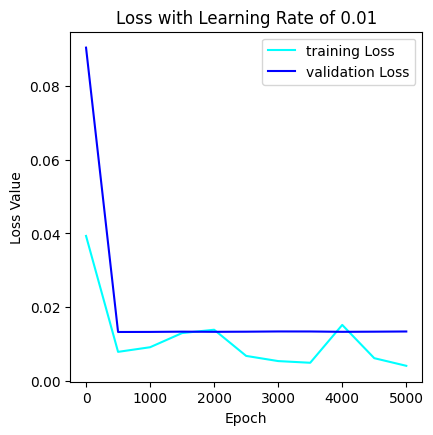

In [32]:
plt.figure(figsize=(10, 10))

plt.subplot(2,2,1)
plt.plot(epochs, np.array([item.detach().item() for item in train_loss_2]), color='cyan', label = 'training Loss')
plt.plot(epochs, np.array([item.detach().item() for item in val_loss_2]), color='blue', label = 'validation Loss')
plt.title('Loss with Learning Rate of 0.01')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

plt.show()


In [33]:
!pip install ipython-autotime
%load_ext autotime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.6 MB/s eta 0:00:00
time: 925 µs (started: 2023-12-02 07:04:18 +00:00)


In [34]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


time: 391 ms (started: 2023-12-02 07:05:13 +00:00)


In [35]:
torch.manual_seed(123)

time: 4.15 ms (started: 2023-12-02 07:05:15 +00:00)


In [36]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Calculate mean and std
imgs = torch.stack([img_t for img_t, _ in train_dataset], dim=3)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)


100%|██████████| 170498071/170498071 [00:02<00:00, 79221577.38it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
time: 24.5 s (started: 2023-12-02 07:05:16 +00:00)


In [37]:
mean

tensor([0.4914, 0.4822, 0.4465])

time: 23.5 ms (started: 2023-12-02 07:05:41 +00:00)


In [39]:
std

tensor([0.2470, 0.2435, 0.2616])

time: 3.68 ms (started: 2023-12-02 07:05:44 +00:00)


In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

time: 798 µs (started: 2023-12-02 07:05:46 +00:00)


In [41]:
device

device(type='cpu')

time: 3.64 ms (started: 2023-12-02 07:05:48 +00:00)


In [42]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
])

time: 996 µs (started: 2023-12-02 07:05:51 +00:00)


In [43]:
cifar10 = datasets.CIFAR10(
    './data', train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

time: 654 ms (started: 2023-12-02 07:05:54 +00:00)


In [44]:
cifar10_val = datasets.CIFAR10(
     './data', train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

time: 423 ms (started: 2023-12-02 07:05:58 +00:00)


In [45]:
first_image, label = cifar10[0]
print(first_image.shape)

torch.Size([3, 32, 32])
time: 7.39 ms (started: 2023-12-02 07:06:00 +00:00)


In [46]:
train_loader = DataLoader(cifar10, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(cifar10_val, batch_size=32, shuffle=False, num_workers=2)


time: 1.31 ms (started: 2023-12-02 07:06:03 +00:00)


In [47]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32 * 32 * 3, 512),
    nn.Tanh(),
    nn.Linear(512, 10)
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

time: 24.5 ms (started: 2023-12-02 07:06:07 +00:00)


In [48]:
def train_model(model, train_loader, test_loader, num_epochs=300, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        model.eval()
        correct = 0
        total = 0
        all_predicted = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_predicted.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = correct / total

        if epoch % 1 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Test Accuracy: {accuracy * 100:.2f}%')
    report = classification_report(all_labels, all_predicted)
    print("Classification Report:\n", report)


time: 2.79 ms (started: 2023-12-02 07:06:14 +00:00)


In [ ]:
train_model(model, train_loader, test_loader, num_epochs=300, lr=0.01)

Epoch 1/300, Loss: 1.7886348081870638, Test Accuracy: 40.94%
Epoch 2/300, Loss: 1.6521172705020037, Test Accuracy: 43.15%
Epoch 3/300, Loss: 1.5804378465437692, Test Accuracy: 44.45%
Epoch 4/300, Loss: 1.5198366514246813, Test Accuracy: 45.26%
Epoch 5/300, Loss: 1.4625313013544161, Test Accuracy: 46.44%
Epoch 6/300, Loss: 1.4085316710646, Test Accuracy: 47.50%
Epoch 7/300, Loss: 1.3539841107580803, Test Accuracy: 47.11%
Epoch 8/300, Loss: 1.3031534532744078, Test Accuracy: 47.23%
Epoch 9/300, Loss: 1.249340126015632, Test Accuracy: 48.36%
Epoch 10/300, Loss: 1.1990976107097633, Test Accuracy: 47.90%
Epoch 11/300, Loss: 1.147438968516891, Test Accuracy: 48.39%
Epoch 12/300, Loss: 1.0958708692496966, Test Accuracy: 49.10%
Epoch 13/300, Loss: 1.0460041413990564, Test Accuracy: 48.73%
Epoch 14/300, Loss: 0.9943198018247931, Test Accuracy: 48.12%
Epoch 15/300, Loss: 0.9466876947223873, Test Accuracy: 48.06%
Epoch 16/300, Loss: 0.8974496146195681, Test Accuracy: 48.03%
Epoch 17/300, Loss: 0.

In [ ]:
model2 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32 * 32 * 3, 512),
    nn.Tanh(),
    nn.Linear(512, 256),
    nn.Tanh(),
    nn.Linear(256, 128),
    nn.Tanh(),
    nn.Linear(128, 10)
).to(device)


time: 32.7 ms (started: 2023-12-02 03:48:01 +00:00)


In [ ]:
train_model(model2, train_loader, test_loader, num_epochs=300, lr=0.01)


Epoch 1/300, Loss: 1.8558505537871435, Test Accuracy: 39.45%
Epoch 2/300, Loss: 1.6909914083078132, Test Accuracy: 42.14%
Epoch 3/300, Loss: 1.6219094949735713, Test Accuracy: 43.75%
Epoch 4/300, Loss: 1.5618384811867527, Test Accuracy: 44.91%
Epoch 5/300, Loss: 1.5054588559645532, Test Accuracy: 46.76%
Epoch 6/300, Loss: 1.4501071075789074, Test Accuracy: 47.13%
Epoch 7/300, Loss: 1.3931976660885874, Test Accuracy: 47.28%
Epoch 8/300, Loss: 1.3340140815659813, Test Accuracy: 48.18%
Epoch 9/300, Loss: 1.2791666287073171, Test Accuracy: 48.68%
Epoch 10/300, Loss: 1.2184916187080144, Test Accuracy: 45.78%
Epoch 11/300, Loss: 1.162105160917293, Test Accuracy: 49.30%
Epoch 12/300, Loss: 1.100820230278386, Test Accuracy: 47.51%
Epoch 13/300, Loss: 1.0398080729934853, Test Accuracy: 49.00%
Epoch 14/300, Loss: 0.9811650063468338, Test Accuracy: 47.63%
Epoch 15/300, Loss: 0.9163863366792695, Test Accuracy: 47.34%
Epoch 16/300, Loss: 0.854968734948359, Test Accuracy: 45.03%
Epoch 17/300, Loss: 